# Advanced Data Analysis using Python

[Matthew McKay](https://github.com/mmcky)

In this notebook we demonstrate a few of the ``Python`` ecosystem tools that enable **research** in areas that can be difficult to do using traditional tools such as ``Stata`` that are typically fit-for-purpose tools. 

The agility of a full programming language environment allows for a high degree of flexibility and the Python ecosystem provides a vast toolkit to remain productive. 

## Table of Contents

1. The Product Space Network (Hidalgo, 2007)
2. Quick introduction to Networks and Graphs
3. Replicate Product Space Proximity Measure
    - Compute Revealed Comparative Advantage and $M_{cp}$ matrices [**Tools: Pandas**] (786 Products, 200+ Countries, and 53 Years)
    - Compute Proximity Matrices ($\phi_{pp'}$) and make this code run fast [**Tools: Pandas, Numpy, Numba, Dask**]
    - (Extension) Building Networks and Plotting Product Space Network Diagrams - albiet not as fancy [**Tools: NetworkX**]


#### Atlas of Complexity Product Space Map

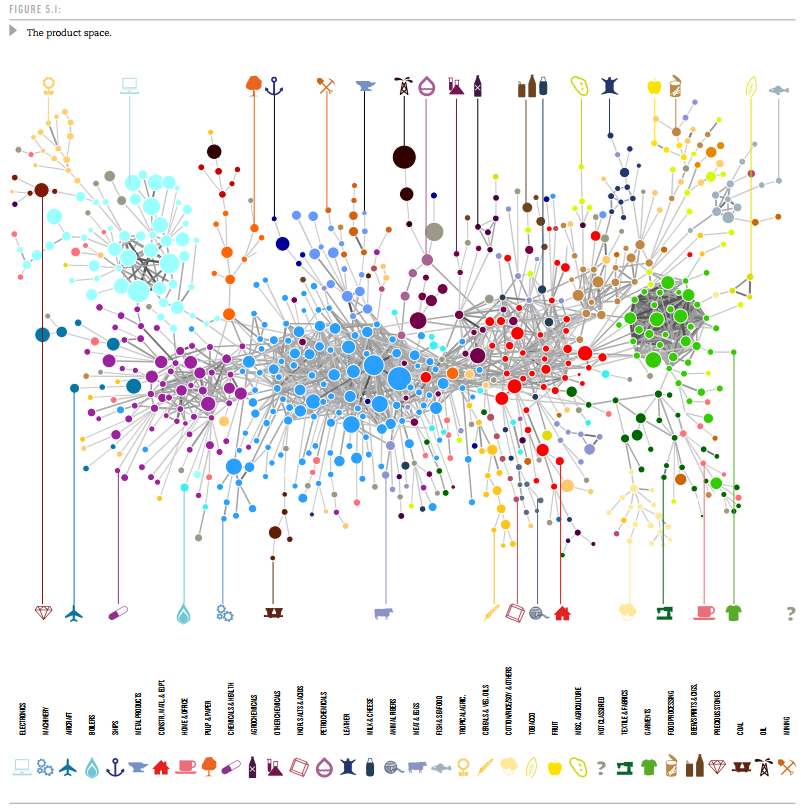

In [1]:
from IPython.display import Image
Image("img/atlas_productspace.png")

#### Some Initial Observations

**Oil (3330)**, has a large world export share, but is not strongly co-exported (i.e. connected in the network) with any other products (other than LNG). 

**Machinery, Electronics, Garments** are all sectors that have a high degree of co-export potential with other related products and form part of a densely connected core of the network.

**Developing Economies** typically occupy products in the **weakly connected periphery** of the network and **new products** tend to emerge close to exisiting products in the network. (established from analysis using the Product Space network). Middle Income Countries manage to diffuse into the densely connected core of the product space

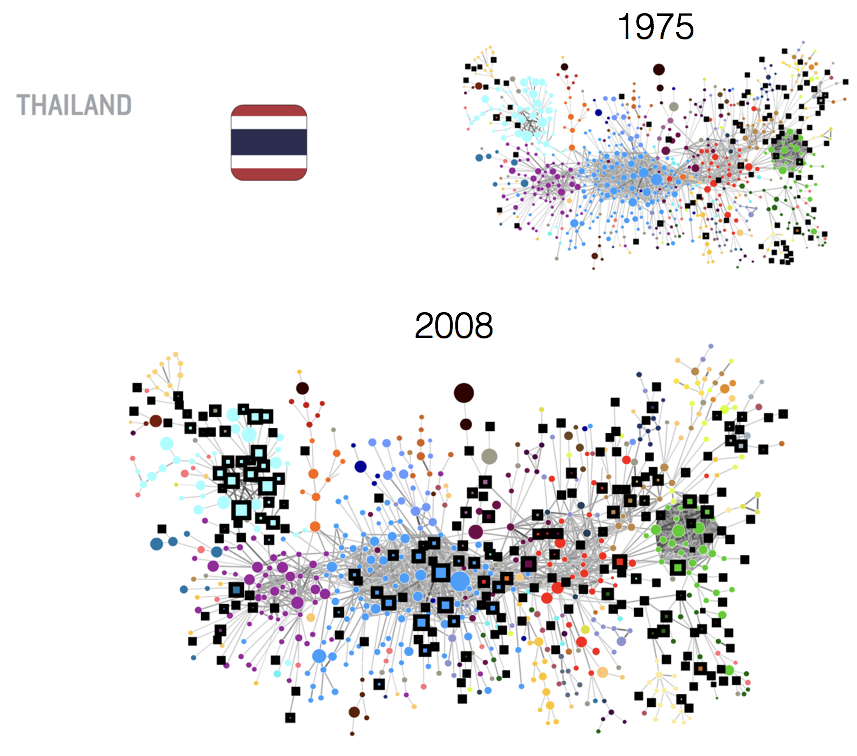

In [2]:
Image("img/thailand-productspace.png")

--------------

## Network Analysis

Interest in studying networks is increasing within **Economics** with recent publications building network type features into their models, or using network analysis to uncover structural features of data that may otherwise go unexplored. 


## What is a Network (Graph)?

Many people who have interacted with tools from network analysis have done so via the idea of Social Network Analysis (SNA). 

    A Graph is a way of specifying relationships among a collection of items

They consist of a collection of **nodes** (or vertices) that are joined together by **edges**. 



In [3]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [4]:
g = nx.Graph()

In [5]:
g.add_nodes_from(["A", "B", "C", "D"])

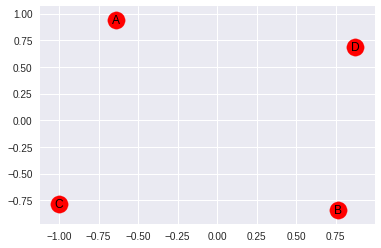

In [6]:
nx.draw_networkx(g)
plt.show()

In [7]:
g.add_edge("A", "B")   #Add Edge between Nodes A and B
g.add_edge("A", "C")   #Add Edge between Nodes A and C
g.add_edge("A", "D")   #Add Edge between Nodes A and D

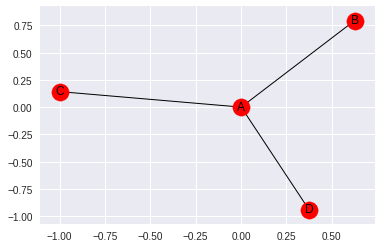

In [8]:
nx.draw_networkx(g)
plt.show()

#### You can use network metrics to learn more about the structure. What is the most central node?

In [9]:
nx.degree_centrality(g)

{'A': 1.0,
 'B': 0.3333333333333333,
 'C': 0.3333333333333333,
 'D': 0.3333333333333333}

In [10]:
g.add_edge("C","D")

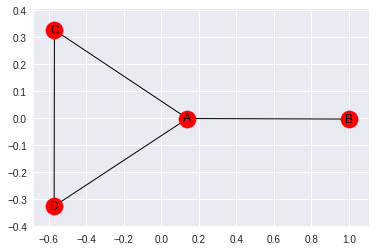

In [11]:
nx.draw_networkx(g)
plt.show()

In [12]:
nx.degree_centrality(g)

{'A': 1.0,
 'B': 0.3333333333333333,
 'C': 0.6666666666666666,
 'D': 0.6666666666666666}

## What can we learn from Networks?

### Social Network Example: Karate Club (Zachary, 1977)

One early example of Social Network Analysis was conducted by Zachary (1977) who set out to use network analysis to explain factional dynamics and to understand **fission in small groups.** A network of **friendship** was used to understand and identify how this Karate group eventually split due to an initial conflict between two members.

- **Nodes:** Individuals
- **Edges:** Connections were added between two individuals if they were consistently observed to interact outside the normal activities of the club. 


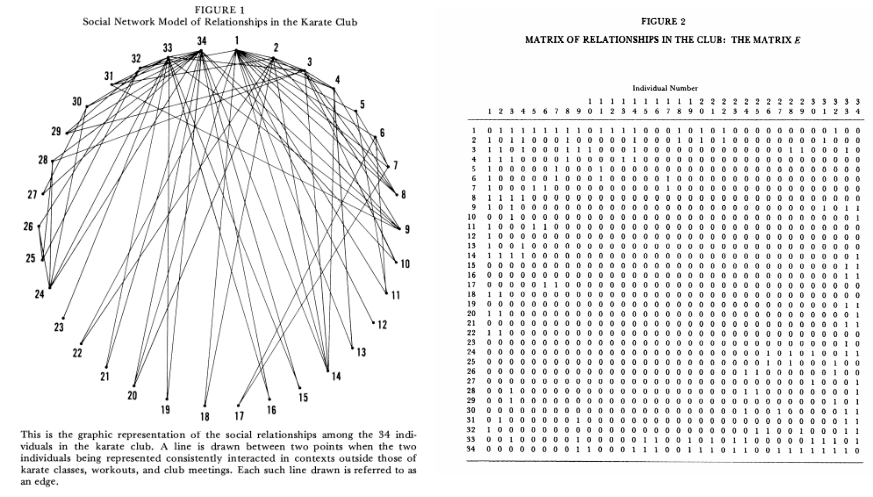

In [13]:
Image("img/karate-club-1-combined.png")

#### We can learn things by considering the structure of these networks

The structure of these relationships can be exploited to uncover new insights into the data:

1. Communities (through Clustering)
1. Identification of main actors in Social Networks (Centrality Metrics)
1. Identifying indirect relationships through shortest / longest paths
1. Diffusion characteristics on temporal networks (such as disease transmission modeling)
1. ... + many other applications across many different sciences

One visualization (Cao, 2013) demonstrates how algorithmic analysis can reveal meaningful structure that clearly identifies roles played by certain individuals, that is based on observing simpler relational information on friendship between pairs of individuals. 

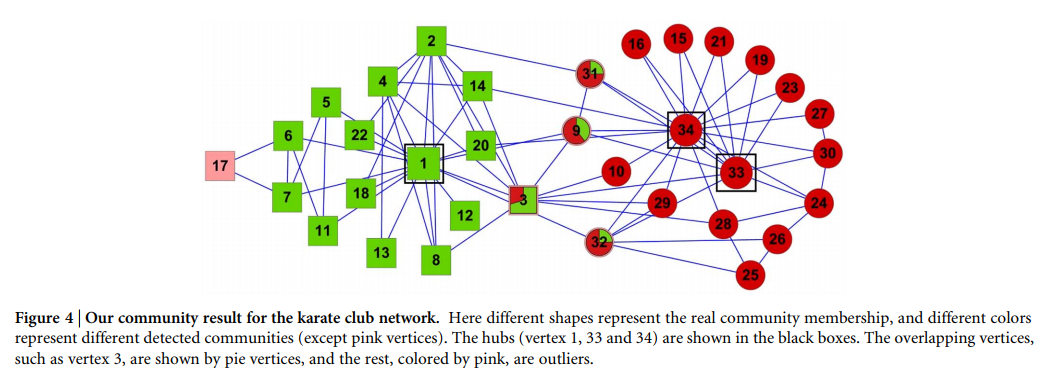

In [14]:
Image("img/karate-club-2.png")

------------------

## Replicating the Product Space Network using International Trade Data (Hidalgo, 2007)

Let's focus on an application of network analysis that is applied to international trade data to replicate some of the results contained in the Hidalgo (2007) paper and later in the [The Atlas of Complexity](http://atlas.cid.harvard.edu/) and [The Observatory of Economic Complexity](http://atlas.media.mit.edu/en/).

The Hidalgo (2007) paper is used as a **motivating example** to demonstrate various tools that are available in the ``Python`` ecosystem.

In this setting we want to looking at a characterisation of International Trade data by considering:
- **Nodes:** Products
- **Edges:** the likelihood of two products being co-exported

**Assumption:** If products are highly co-exported across countries, then the products are *revealed* to be more likely to share similar factors of production (or capabilities) required to produce them. For example, Shirts and Pants require a set of similar skills that lend themselves to be co-exported, while shirts and cars are much more dissimilar.

This relational information between products can be represented by a edge weights. 

A **high value** means they have a **high likelihood of being co-exported** 

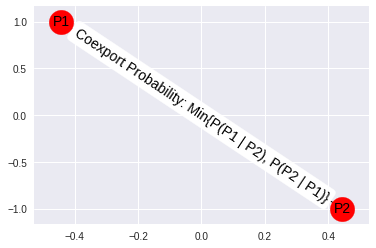

In [15]:
g = nx.Graph()
g.add_edge("P1", "P2")
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos=pos, node_size=600, font_size=14)
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels={("P1", "P2") : "Coexport Probability: Min{P(P1 | P2), P(P2 | P1)}"}, font_size=14)
plt.show()

#### Let's work with a Toy Example with 8 products

In [16]:
adj = pd.read_csv("./data/simple_productspace.csv", names=["P1", "P2", "weight"])
adj

P1        P2  weight
0   Shirts     Pants   0.900
1   Shirts      Cars   0.050
2   Shirts      Cows   0.010
3   Shirts     Sugar   0.010
4    Pants      Cars   0.050
5      Oil     Sugar   0.010
6      Oil      Cars   0.005
7      Oil  Aircraft   0.005
8     Cars  Aircraft   0.500
9     Cars  Aircraft   0.500
10   Wheat     Sugar   0.400
11   Wheat      Cows   0.200
12    Cows     Sugar   0.100
13    Cows      Cars   0.001
14    Cows     Pants   0.060

In [17]:
g = nx.read_weighted_edgelist("./data/simple_productspace.csv", delimiter=",")

In [18]:
g.nodes()

NodeView(('Shirts', 'Pants', 'Cars', 'Cows', 'Sugar', 'Oil', 'Aircraft', 'Wheat'))

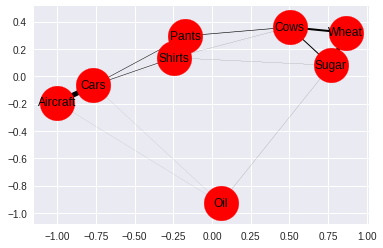

In [19]:
#Visualize the Network
pos = nx.spring_layout(g)
weights = [g[u][v]['weight']*10 for u,v in g.edges()]
nx.draw_networkx(g, node_size=1200, pos=pos, width=weights)
plt.show()

### Scale Up to Full set of Products (SITC R2 L4)

We now want to compute the edge weights to explore the full product space network derived from product level international trade data by computing the proximity matrix:

$$
\phi_{ij} = \min \{ P(RCA_i >= 1 \hspace{0.25cm}| \hspace{0.25cm} RCA_j >= 1), P(RCA_j >= 1 \hspace{0.25cm} | \hspace{0.25cm} RCA_i >= 1) \}
$$

**Proximity:** A **high** proximity value suggests any two products are exported by a similar set of countries. 

The **tasks** involve:

1. Compute Revealed Comparative Advantage and $M_{cp}$ matrices [**Tools: Pandas**]
1. Compute Proximity Matrices ($\phi_{pp'}$) and make this code run fast [**Tools: Pandas, Numpy, Numba, Dask**]
1. Building Networks and Plotting Product Space Network Diagrams - *albiet not as fancy* [**Tools: NetworkX**]

--------------------_
# Computing Proximity

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import networkx as nx
from bokeh.io import output_notebook

In [21]:
#-Load Jupyter Extensions-#
%matplotlib inline
output_notebook()

Loading BokehJS ...

## Data

International Trade Data is largely available in SITC and HS product classification systems. 

In this notebook we will focus on SITC revision 2 Level 4 data with ``786`` defined products. 

|Classification | Level | Products |
|---------------|-------|----------|
|SITC           | 4     | 786      |
|HS             | 6     | 5016     |

**Note:** 

We use ``SITC`` data in this seminar, but as you can see performance of code becomes even more important when working with fully disaggregated ``HS`` international trade data

In [22]:
fl = "./data/year_origin_sitc_rev2.csv"
data = pd.read_csv(fl, converters={'sitc':str})   #Import SITC codes as strings to preserve formatting

In [23]:
data.head()

year origin  sitc   export
0  1962    AFG  0230   4000.0
1  1962    AFG  0250  66000.0
2  1962    AFG  0540  74000.0
3  1962    AFG  0545  17000.0
4  1962    AFG  0548  33000.0

### Question 1: What years are available in this dataset?

**Hint:** There is a method named ``unique()``, so you should get the array of years and then call ``.unique()``

In [24]:
data['year'].unique()

array([1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])

### Question 2: How many non-zero trade flow values are in this dataset?

In [25]:
data['year'].unique()

array([1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])

### Question 3: What countries are available in this dataset?

In [26]:
data['origin'].unique()

array(['AFG', 'AGO', 'ALB', 'ARE', 'ARG', 'AUS', 'AUT', 'BDI', 'BEL',
       'BEN', 'BFA', 'BGR', 'BHR', 'BHS', 'BLZ', 'BMU', 'BOL', 'BRA',
       'BRB', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD',
       'COG', 'COL', 'CRI', 'CSK', 'CUB', 'CYP', 'DDR', 'DEU', 'DJI',
       'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'ETH', 'FDR', 'FIN',
       'FIO', 'FJI', 'FRA', 'GAB', 'GBR', 'GHA', 'GIB', 'GIN', 'GLP',
       'GMB', 'GNB', 'GNQ', 'GRC', 'GTM', 'GUF', 'GUY', 'HKG', 'HND',
       'HTI', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR',
       'ITA', 'JAM', 'JOR', 'JPN', 'KEN', 'KHM', 'KIR', 'KOR', 'KWT',
       'LAO', 'LBN', 'LBR', 'LBY', 'LKA', 'MAC', 'MAR', 'MDG', 'MEX',
       'MLI', 'MLT', 'MMR', 'MNG', 'MOZ', 'MRT', 'MUS', 'MYS', 'NCL',
       'NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 'NZL', 'OMN', 'PAK',
       'PAN', 'PER', 'PHL', 'PNG', 'POL', 'PRK', 'PRT', 'PRY', 'QAT',
       'ROU', 'SAU', 'SDN', 'SEN', 'SGP', 'SLE', 'SLV', 'SOM', 'SPM',
       'SUN', 'SUR',

In [27]:
data[(data['year'] == 2000)&(data['origin']=="AUS")].head()

year origin  sitc       export
2213361  2000    AUS  0011  260132101.0
2213362  2000    AUS  0012  167611315.0
2213363  2000    AUS  0013     280098.0
2213364  2000    AUS  0014     548603.0
2213365  2000    AUS  0015  134571371.0

In [28]:
data[data['origin'] == 'AUS'].set_index(["year","sitc"])["export"].unstack(level="year").head()

year       1962       1963       1964       1965       1966       1967  \
sitc                                                                     
0010        NaN        NaN        NaN     1000.0        NaN        NaN   
0011  1286000.0   675000.0  1177000.0  1700000.0   748000.0   548000.0   
0012  2600000.0  3619000.0  5593000.0  3560000.0  4725000.0  5078000.0   
0013    26000.0    52000.0    81000.0    69000.0    60000.0    32000.0   
0014   375000.0   398000.0   445000.0   187000.0    83000.0    73000.0   

year       1968       1969        1970        1971      ...              2005  \
sitc                                                    ...                     
0010        NaN     1000.0         NaN         NaN      ...               NaN   
0011   586000.0   747000.0    331000.0    443000.0      ...       283381176.0   
0012  5578000.0  6828000.0  11517000.0  13321000.0      ...       211748259.0   
0013    99000.0   108000.0    108000.0    189000.0      ...          260620.0   
0014    30000.0    83000.0    263000.0    258000.0      ...          592790.0   

year         2006         2007         2008         2009         2010  \
sitc                                                                    
0010          NaN          NaN          NaN          NaN          NaN   
0011  284544151.0  365401097.0  571444736.0  586230117.0  793934945.0   
0012  215548475.0  216467212.0  307677017.0  296862273.0  319842757.0   
0013     309274.0     549802.0     153458.0      37764.0     224888.0   
0014    2842029.0    3599939.0    4708910.0    6542608.0    5466152.0   

year         2011         2012         2013          2014  
sitc                                                       
0010          NaN          NaN          NaN           NaN  
0011  650001457.0  627274883.0  728998394.0  1.114734e+09  
0012  347639153.0  296233596.0  174194459.0  2.209887e+08  
0013          NaN          NaN     345256.0  2.302240e+05  
0014    5372783.0    4237839.0    1165708.0  3.056300e+05  

[5 rows x 53 columns]

---------------

## Computing Revealed Comparative Advantage

The literature uses the standard Balassa definition for Revealed Comparative Advantage

$$
\large
RCA_{cpt} = \frac{\frac{E_{cpt}}{E_{ct}}}{\frac{E_{pt}}{E_t}}
$$

where,

1. $E_{cpt}$ are exports from country $c$ in product $p$ at time $t$
1. $E_{ct}$ are total country $c$ exports at time $t$
1. $E_{pt}$ are total product $p$ exports at time $t$
1. $E_{t}$ are total world exports at time $t$

**Reference:** Balassa, B. (1965), Trade Liberalisation and Revealed Comparative Advantage, The Manchester School, 33, 99-123.

To compute **RCA** we need to aggregate data at difference levels to obtain each component of the fraction defined above. 

Let's break the equation down to figure out what needs to be computed:

$$
\large
E_{ct} = \sum_{p}{E_{cpt}}
$$

In [29]:
cntry_export = data[["year", "origin", "export"]].groupby(by=["year", "origin"]).sum()
cntry_export.head(n=2)

export
year origin             
1962 AFG      86135000.0
     AGO     119458000.0

This gives us a ``pandas.DataFrame`` that is indexed by a multi-index object. This can be very useful but we would like to use this data in the original data table for each product exported at time t by each country. We could use this new object and:

1. ``merge`` the data back into the original data DataFrame
2. use ``transform`` to request an object that is of the same shape as the original data DataFrame. 

In [30]:
data["cntry_export"] = data[["year", "origin", "export"]].groupby(by=["year", "origin"]).transform(np.sum)
data["prod_export"] = data[["year", "sitc", "export"]].groupby(by=["year", "sitc"]).transform(np.sum)
data["world_export"] = data[["year", "export"]].groupby(by=["year"]).transform(np.sum)

Now that the components of the equation have been computed we can now simply calculate $RCA$ as expressed by the original fraction

In [31]:
data["rca"] = (data["export"] / data["cntry_export"]) / (data["prod_export"] / data["world_export"])

In [32]:
data.head()

year origin  sitc   export  cntry_export  prod_export  world_export  \
0  1962    AFG  0230   4000.0    86135000.0  438581000.0  1.428420e+11   
1  1962    AFG  0250  66000.0    86135000.0  261448000.0  1.428420e+11   
2  1962    AFG  0540  74000.0    86135000.0   48924000.0  1.428420e+11   
3  1962    AFG  0545  17000.0    86135000.0  349188000.0  1.428420e+11   
4  1962    AFG  0548  33000.0    86135000.0   85126000.0  1.428420e+11   

        rca  
0  0.015125  
1  0.418634  
2  2.508338  
3  0.080736  
4  0.642877

--------------
## Computing $M_{cp}$ Matrix: Who Exports What Products and When?

$RCA >= 1$ is where country $c$ has a revealed comparative advantage in product $p$ at time $t$

Therefore we can define the matrix $M_{cp}$:

$$
M_{cp} = 
\begin{cases}
  1 \text{ if  }RCA \ge 1\\    
  0 \text{ if  }RCA \lt 1   
\end{cases}
$$

We can first construct $RCA$ matrices and then compute $M_{cp}$ using a conditional map


In [33]:
#-Generate Yearly RCA Mcp Matrices and store them in a Dictionary-#
rca = {}
for year in data.year.unique():
    yr = data[data.year == year].set_index(['origin', 'sitc']).unstack('sitc')['rca']
    rca[year] = yr

In [34]:
rca[2000].head()

sitc    0011  0012      0013  0014  0015       0111      0112      0113  \
origin                                                                    
ABW      NaN   NaN       NaN   NaN   NaN   0.000189       NaN  0.008223   
AFG      NaN   NaN       NaN   NaN   NaN   0.176481  0.066896       NaN   
AGO      NaN   NaN  0.000012   NaN   NaN   0.001756       NaN       NaN   
AIA      NaN   NaN       NaN   NaN   NaN  15.716737  6.270237       NaN   
ALB      NaN   NaN       NaN   NaN   NaN        NaN       NaN       NaN   

sitc        0114  0115   ...         8994      8996      8997      8998  \
origin                   ...                                              
ABW          NaN   NaN   ...          NaN  0.009006  0.000910  0.006053   
AFG          NaN   NaN   ...          NaN  0.067773  0.782384       NaN   
AGO          NaN   NaN   ...          NaN       NaN       NaN  0.000137   
AIA          NaN   NaN   ...          NaN       NaN       NaN       NaN   
ALB     0.006836   NaN   ...     0.304894  0.014938  0.146457  0.093441   

sitc        8999      9310       9410  9510      9610     9710  
origin                                                          
ABW     0.001468  1.264113   0.104766   NaN       NaN  0.76756  
AFG          NaN  0.066374        NaN   NaN       NaN      NaN  
AGO          NaN  0.026715        NaN   NaN  0.005944      NaN  
AIA     0.649915  6.906314        NaN   NaN       NaN      NaN  
ALB          NaN  0.357895  25.006762   NaN  3.426721      NaN  

[5 rows x 775 columns]

### Question 6: How can we use ``rca`` to compute the ``mcp`` matrix?

In [35]:
#-Generate Yearly Binary Mcp Matrices-#
mcp = {}
for year in rca.keys():
    mcp[year] = rca[year].fillna(0.0).applymap(lambda x: 1 if x >= 1.0 else 0.0)

### Question: What is the key assumption implied by the above code?

In [36]:
mcp[2000].head()

sitc    0011  0012  0013  0014  0015  0111  0112  0113  0114  0115  ...   \
origin                                                              ...    
ABW      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
AFG      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
AGO      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
AIA      0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0  ...    
ALB      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    

sitc    8994  8996  8997  8998  8999  9310  9410  9510  9610  9710  
origin                                                              
ABW      0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0  
AFG      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
AGO      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
AIA      0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0  
ALB      0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   1.0   0.0  

[5 rows x 775 columns]

### Question 6: What products did Australia ("AUS") export with RCA in 1998?

In [37]:
products = mcp[1998].loc['AUS']
products[products == 1.0]

sitc
0011    1.0
0012    1.0
0015    1.0
0111    1.0
0112    1.0
0115    1.0
0116    1.0
0118    1.0
0141    1.0
0223    1.0
0224    1.0
0230    1.0
0240    1.0
0341    1.0
0360    1.0
0372    1.0
0411    1.0
0412    1.0
0421    1.0
0422    1.0
0430    1.0
0452    1.0
0459    1.0
0460    1.0
0470    1.0
0481    1.0
0482    1.0
0488    1.0
0542    1.0
0545    1.0
       ... 
6749    1.0
6781    1.0
6793    1.0
6811    1.0
6821    1.0
6831    1.0
6832    1.0
6841    1.0
6842    1.0
6851    1.0
6852    1.0
6861    1.0
6863    1.0
6872    1.0
6899    1.0
6932    1.0
7131    1.0
7163    1.0
7283    1.0
7411    1.0
7911    1.0
7913    1.0
7931    1.0
8744    1.0
8822    1.0
8960    1.0
8996    1.0
9410    1.0
9610    1.0
9710    1.0
Name: AUS, Length: 159, dtype: float64

--------------

## Computing Proximity Matrix $\phi_{ij}$

**Proximity:** A **high** proximity value suggests any two products are exported by a similar set of countries. 

$$
\phi_{ij} = \min \{ P(RCA_i >=1 \hspace{0.25cm} | \hspace{0.25cm} RCA_j >= 1), P(RCA_j >= 1 \hspace{0.25cm} | \hspace{0.25cm} RCA_i >= 1) \}
$$

The minimum **conditional probability of coexport** can be computed:

$$
\phi_{ij} = \frac{\sum_c \{ M_{cp_i} * M_{cp_j} \}}{max \{k_{p_i}, k_{p_j}\}}
$$

where,

1. $k_{p_i}$ is the ubiquity of product $i$ (i.e. the number of countries that export product $i$)
2. $k_{p_j}$ is the ubiquity of product $j$ (i.e. the number of countries that export product $j$)
2. $M_{cp_i}$ is the column vector in $M_{cp}$ matrix for product $i$
3. $M_{cp_j}$ is the column vector in $M_{cp}$ matrix for product $j$
4. $\sum_c \{ M_{cp_i} * M_{cp_j} \}$ is the number of countries that export both product $i$ and product $j$

The $\phi_{ij}$ matrix is therefore computed through all pairwise combinations of column vectors which is computationally intensive.

### Step 1: Compute Proximity Matrix using Pandas

In [38]:
def proximity_matrix_pandas(mcp, fillna=True):
    products = sorted(list(mcp.columns))
    sum_products = mcp.sum(axis=0)
    proximity = pd.DataFrame(index=products, columns=products)
    for i, product1 in enumerate(products):
        for j, product2 in enumerate(products):
            if j > i:  #Symmetric Matrix Condition
                continue
            numerator = (mcp[product1] * mcp[product2]).sum()
            denominator = max(sum_products[product1], sum_products[product2])
            if denominator == 0:
                cond_prob =  np.nan
            else:
                cond_prob = numerator / denominator
            proximity.set_value(index=product1, col=product2, value=cond_prob)
            proximity.set_value(index=product2, col=product1, value=cond_prob)
    if fillna:
        proximity = proximity.fillna(0.0)
    return proximity

In [39]:
%%time
prox_2000 = proximity_matrix_pandas(mcp[2000])

/home/mmcky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app
/home/mmcky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


CPU times: user 1min 11s, sys: 212 ms, total: 1min 11s
Wall time: 1min 11s


#### Check the Data (simple stats and visualizations)

Hidalgo (2007) suggests that 32% of values are < 0.1 and 65% of values are < 0.2

In [40]:
prox_2000.unstack().describe()

count    600625.000000
mean          0.159894
std           0.106652
min           0.000000
25%           0.081081
50%           0.142857
75%           0.222222
max           1.000000
dtype: float64

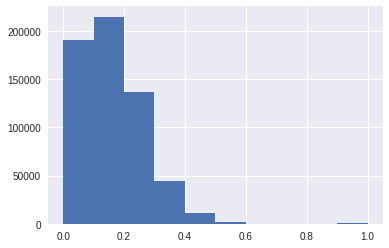

In [41]:
prox_2000.unstack().hist()

## But Wait - Problem!

at **~1 minute** this is taking a reasonably long time to compute for one year.  This makes working with this data in an agile way problematic and computing for 50 years would take an hour to compute. While this was easy to implement, it isn't very fast!

Let's **profile** this code to get an understanding where we spend most of our time

For this line to run you will need to install ``line_profiler`` by running:

```bash
conda install line_profiler
```

In [42]:
# !conda install line_profiler

In [43]:
import line_profiler
%load_ext line_profiler

In [44]:
# %lprun -f proximity_matrix_pandas proximity_matrix_pandas(mcp[2000])

--------------

## Step 2: Consider other Python Tools (NumPy)

Most of the time you will want to conduct **numerical** type computing in NumPy.

The code actually looks pretty similar - the main difference is conducting operations on pure numpy arrays

In [45]:
def proximity_matrix_numpy(mcp, fillna=False):
    products = sorted(list(mcp.columns))
    num_products = len(products)
    proximity = np.empty((num_products, num_products))
    col_sums = mcp.sum().values  
    data = mcp.T.as_matrix()                  #This generates a c x p numpy array
    for index1 in range(0,num_products):
        for index2 in range(0,num_products):
            if index2 > index1:
                continue
            numerator = (data[index1] * data[index2]).sum()
            denominator = max(col_sums[index1], col_sums[index2])
            if denominator == 0.0:
                cond_prob = np.nan
            else:
                cond_prob = numerator / denominator
            proximity[index1][index2] = cond_prob
            proximity[index2][index1] = cond_prob
    # Return DataFrame Representation #
    proximity = pd.DataFrame(proximity, index=products, columns=products)
    proximity.index.name = 'productcode1'
    proximity.columns.name = 'productcode2'
    if fillna:
        proximity = proximity.fillna(0.0)
    return proximity

In [46]:
%%time
prox_2000_numpy = proximity_matrix_numpy(mcp[2000])

CPU times: user 2.27 s, sys: 0 ns, total: 2.27 s
Wall time: 2.27 s


In [47]:
prox_2000.equals(prox_2000_numpy)

True

------------------------

## Step 3: Just in Time Compilation (Numba)

**Numba** is a package you can use to accelerate your code by using a technique called **just in time (or JIT)** compilation. It converts your high-level python code to low level llvm code to run it closer to the raw machine level. 

``nopython=True`` ensures the ``jit`` compiles without any ``python`` objects. If it cannot achieve this it will throw an error.

**Numba** now supports a lot of the ``NumPy`` api and can be checked [here](http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html)

In [48]:
@jit(nopython=True)
def coexport_probability(data, num_products, col_sums):
    proximity = np.empty((num_products, num_products))
    for index1 in range(0,num_products):
        for index2 in range(0,num_products):
            if index2 > index1:
                continue
            numerator = (data[index1] * data[index2]).sum()
            denominator = max(col_sums[index1], col_sums[index2])
            if denominator == 0.0:
                cond_prob = np.nan
            else:
                cond_prob = numerator / denominator
            proximity[index1][index2] = cond_prob
            proximity[index2][index1] = cond_prob
    return proximity

def proximity_matrix_numba(mcp, fillna=False):
    products = sorted(list(mcp.columns))
    num_products = len(products)
    col_sums = mcp.sum().values  
    data = mcp.T.as_matrix()                  
    proximity = coexport_probability(data, num_products, col_sums)   #Call Jit Function
    # Return DataFrame Representation #
    proximity = pd.DataFrame(proximity, index=products, columns=products)
    proximity.index.name = 'productcode1'
    proximity.columns.name = 'productcode2'
    if fillna:
        proximity = proximity.fillna(0.0)
    return proximity

In [49]:
prox_2000_numba = proximity_matrix_numba(mcp[2000])

In [50]:
%%timeit
prox_2000_numba = proximity_matrix_numba(mcp[2000])

126 ms ± 351 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [51]:
prox_2000_numba.equals(prox_2000)

True

### Computing All Years

In [52]:
%%time
proximity = {}
for year in mcp.keys():
    proximity[year] = proximity_matrix_numba(mcp[year])

CPU times: user 6.07 s, sys: 88 ms, total: 6.16 s
Wall time: 6.16 s


In [53]:
proximity[2000].head()

productcode2      0011      0012      0013      0014      0015     0111  \
productcode1                                                              
0011          1.000000  0.448276  0.206897  0.206897  0.275862  0.37500   
0012          0.448276  1.000000  0.178571  0.107143  0.321429  0.25000   
0013          0.206897  0.178571  1.000000  0.227273  0.100000  0.12500   
0014          0.206897  0.107143  0.227273  1.000000  0.181818  0.15625   
0015          0.275862  0.321429  0.100000  0.181818  1.000000  0.28125   

productcode2      0112      0113      0114      0115  ...        8994  \
productcode1                                          ...               
0011          0.275862  0.344828  0.206897  0.241379  ...    0.068966   
0012          0.392857  0.142857  0.178571  0.142857  ...    0.035714   
0013          0.083333  0.500000  0.312500  0.153846  ...    0.153846   
0014          0.125000  0.318182  0.363636  0.090909  ...    0.090909   
0015          0.250000  0.150000  0.200000  0.250000  ...    0.050000   

productcode2      8996      8997      8998      8999      9310      9410  \
productcode1                                                               
0011          0.137931  0.162791  0.068966  0.034483  0.244898  0.178082   
0012          0.178571  0.116279  0.071429  0.000000  0.163265  0.219178   
0013          0.210526  0.093023  0.080000  0.142857  0.163265  0.095890   
0014          0.181818  0.139535  0.120000  0.045455  0.142857  0.178082   
0015          0.350000  0.139535  0.040000  0.050000  0.122449  0.150685   

productcode2      9510      9610   9710  
productcode1                             
0011          0.206897  0.137931  0.175  
0012          0.071429  0.107143  0.125  
0013          0.090909  0.071429  0.075  
0014          0.409091  0.045455  0.200  
0015          0.136364  0.150000  0.125  

[5 rows x 775 columns]

--------------------

## Using Dask to Compute all Years in Parallel

#### NOTE: THIS WON'T WORK ON DEMO DOCKER ENVIRONMENT

Now that we have a fast single year computation, we can compute all cross-sections serially using a loop.

Alternatively, we can parallelize these operations using ``Dask`` to delay computation and then ask the ``Dask`` scheduler to coordinate the computation over the number of **cores** available to you. This is particularly useful when using ``HS`` data. 

**Note:** This simple approach to parallelization does have some overhead to coordinate the computations so you won't get a full 4 x speed up when using a 4-core machine. 

In [54]:
import dask
from distributed import Client
Client()

<Client: scheduler='tcp://127.0.0.1:36195' processes=8 cores=8>

In [55]:
#-Setup the Computations as a Collection of Tasks-#
collection = []
for year in sorted(mcp.keys()):
    collection.append((year, dask.delayed(proximity_matrix_numba)(mcp[year])))

In [56]:
%%time
#-Compute the Results-#
result = dask.compute(*collection)

CPU times: user 1.53 s, sys: 1.65 s, total: 3.18 s
Wall time: 5.74 s


In [57]:
#-Organise the list of returned tuples into a convenient dictionary-#
results = {}
for year, df in result:
    results[year] = df

In [58]:
results[2000].equals(prox_2000)

True

In [59]:
results[2000].head()

productcode2      0011      0012      0013      0014      0015     0111  \
productcode1                                                              
0011          1.000000  0.448276  0.206897  0.206897  0.275862  0.37500   
0012          0.448276  1.000000  0.178571  0.107143  0.321429  0.25000   
0013          0.206897  0.178571  1.000000  0.227273  0.100000  0.12500   
0014          0.206897  0.107143  0.227273  1.000000  0.181818  0.15625   
0015          0.275862  0.321429  0.100000  0.181818  1.000000  0.28125   

productcode2      0112      0113      0114      0115  ...        8994  \
productcode1                                          ...               
0011          0.275862  0.344828  0.206897  0.241379  ...    0.068966   
0012          0.392857  0.142857  0.178571  0.142857  ...    0.035714   
0013          0.083333  0.500000  0.312500  0.153846  ...    0.153846   
0014          0.125000  0.318182  0.363636  0.090909  ...    0.090909   
0015          0.250000  0.150000  0.200000  0.250000  ...    0.050000   

productcode2      8996      8997      8998      8999      9310      9410  \
productcode1                                                               
0011          0.137931  0.162791  0.068966  0.034483  0.244898  0.178082   
0012          0.178571  0.116279  0.071429  0.000000  0.163265  0.219178   
0013          0.210526  0.093023  0.080000  0.142857  0.163265  0.095890   
0014          0.181818  0.139535  0.120000  0.045455  0.142857  0.178082   
0015          0.350000  0.139535  0.040000  0.050000  0.122449  0.150685   

productcode2      9510      9610   9710  
productcode1                             
0011          0.206897  0.137931  0.175  
0012          0.071429  0.107143  0.125  
0013          0.090909  0.071429  0.075  
0014          0.409091  0.045455  0.200  
0015          0.136364  0.150000  0.125  

[5 rows x 775 columns]

**Note:** [Dask](https://github.com/dask/dask) does a lot more than this and is worth looking into for medium to large scale computations

In [60]:
#-Save Results into a HDF5 File-#
fl = "data/sitcr2l4_proximity.h5"
store = pd.HDFStore(fl, mode='w')
for year in results.keys():
    store["Y{}".format(year)] = results[year]
store.close()

In [61]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

--------------------------

## Performance Comparison (SITC and HS Data)

For **SITC** Data: (786 Products, 229 Countries, 52 Years)


| Function         | Time/Year        | Total Time  | Speedup |
|------------------|------------------|-------------|---------|
| pandas           | 220 seconds      | ~177 minutes| -       |
| pandas_symmetric | 104 seconds      | ~84 minutes | BASE       |
| numpy            | 2.5 seconds      | 120 seconds | ~41x    |
| numba            | 124 milliseconds | 6 seconds   | ~800x   |
| numba + dask     | N/A              | 5 seconds   | -       |



For **HS** Data: (5016 Products, 222 Countries, 20 Years)

| Function         | Time/Year                    | Total Time | Speedup |
|------------------|------------------------------|------------|---------|
| pandas           | 1 Hour 25 minutes |      -     | -       |
| pandas_symmetric | 43 minutes                   |      -     | BASE       |
| numpy            | 1 min 37 seconds             |      -     | ~28x    |
| numba            | 5 seconds                    | 1min 45 seconds   | ~516x   |
| numba + dask     | N/A                          | 45 seconds      |    -     |

These were run on the following **machine:**

| Item      | Details          |
|-----------|------------------|
| Processor | Xeon E5 @ 3.6Ghz |
| Cores     | 8                |
| RAM       | 32Gb RAM         |
| Python    | Python 3.6       |

------------------_

## (Extension) Preparing Graph Data: Product Space Network

Here we will use ``NetworkX`` to construct our version of the Product Space using Python

In [62]:
prox = pd.read_hdf("data/sitcr2l4_proximity.h5", key="Y2000")

In [63]:
prox.head()

productcode2      0011      0012      0013      0014      0015     0111  \
productcode1                                                              
0011          1.000000  0.448276  0.206897  0.206897  0.275862  0.37500   
0012          0.448276  1.000000  0.178571  0.107143  0.321429  0.25000   
0013          0.206897  0.178571  1.000000  0.227273  0.100000  0.12500   
0014          0.206897  0.107143  0.227273  1.000000  0.181818  0.15625   
0015          0.275862  0.321429  0.100000  0.181818  1.000000  0.28125   

productcode2      0112      0113      0114      0115  ...        8994  \
productcode1                                          ...               
0011          0.275862  0.344828  0.206897  0.241379  ...    0.068966   
0012          0.392857  0.142857  0.178571  0.142857  ...    0.035714   
0013          0.083333  0.500000  0.312500  0.153846  ...    0.153846   
0014          0.125000  0.318182  0.363636  0.090909  ...    0.090909   
0015          0.250000  0.150000  0.200000  0.250000  ...    0.050000   

productcode2      8996      8997      8998      8999      9310      9410  \
productcode1                                                               
0011          0.137931  0.162791  0.068966  0.034483  0.244898  0.178082   
0012          0.178571  0.116279  0.071429  0.000000  0.163265  0.219178   
0013          0.210526  0.093023  0.080000  0.142857  0.163265  0.095890   
0014          0.181818  0.139535  0.120000  0.045455  0.142857  0.178082   
0015          0.350000  0.139535  0.040000  0.050000  0.122449  0.150685   

productcode2      9510      9610   9710  
productcode1                             
0011          0.206897  0.137931  0.175  
0012          0.071429  0.107143  0.125  
0013          0.090909  0.071429  0.075  
0014          0.409091  0.045455  0.200  
0015          0.136364  0.150000  0.125  

[5 rows x 775 columns]

#### use pandas to construct and edge list

In [64]:
edge_list = prox.unstack()

In [65]:
#-Construct Sequence of node pairs as a pd.Series
edge_list.head()

productcode2  productcode1
0011          0011            1.000000
              0012            0.448276
              0013            0.206897
              0014            0.206897
              0015            0.275862
dtype: float64

In [66]:
#-Remove Self Loops-#
edge_list = edge_list[edge_list != 1.0]     #TODO: do this operation properly to compare node1 == node2

In [67]:
edge_list.head()

productcode2  productcode1
0011          0012            0.448276
              0013            0.206897
              0014            0.206897
              0015            0.275862
              0111            0.375000
dtype: float64

#### We would like to construct the maximum_spanning_tree, but the current version of networkx supports minimum_spanning_tree so we need to add inv_weight for this computation. 

In [68]:
#-Construct DataFrame-#
edge_list = edge_list.reset_index()
edge_list.columns = ["P1","P2","weight"]

In [69]:
edge_list["inv_weight"] = 1 - edge_list['weight']    #Useful when working with minimum spanning tree in networkx

In [70]:
edge_list.head()

P1    P2    weight  inv_weight
0  0011  0012  0.448276    0.551724
1  0011  0013  0.206897    0.793103
2  0011  0014  0.206897    0.793103
3  0011  0015  0.275862    0.724138
4  0011  0111  0.375000    0.625000

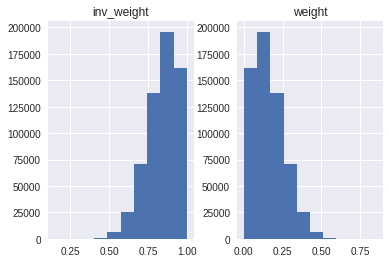

In [71]:
edge_list[["weight","inv_weight"]].hist();

# Network Tools

We want to now construct a maximum_spanning_tree and then add in all nodes that are highly connected above a threshold value of ``0.5``

In [72]:
import networkx as nx

In [73]:
#-Construct the complete network-#
g = nx.from_pandas_edgelist(edge_list, source="P1", target="P2", edge_attr=["weight", "inv_weight"])
print("# of Nodes: {}".format(g.number_of_nodes()))
print("# of Edges: {}".format(g.number_of_edges()))

# of Nodes: 775
# of Edges: 299925


In [74]:
mst = nx.minimum_spanning_tree(g, weight='inv_weight') #Maximum Spanning Tree
print("# of Nodes: {}".format(mst.number_of_nodes()))
print("# of Edges: {}".format(mst.number_of_edges()))

# of Nodes: 775
# of Edges: 774


In [75]:
mst["0011"]

AtlasView({'0012': {'weight': 0.4482758620689655, 'inv_weight': 0.5517241379310345}, '0223': {'weight': 0.4482758620689655, 'inv_weight': 0.5517241379310345}})

In [76]:
#-Build Maximum Spanning Tree + Keep Edges > 0.50-#
ps = nx.Graph()
#Add MST ('weight' attribute only)
for u,v,w in mst.edges(data=True):
    ps.add_edge(u,v,attr_dict={'weight' : w["weight"]})
#Add Edges > 0.50
for u,v,w in g.edges(data=True):
    if w['weight'] >= 0.50:
        ps.add_edge(u,v,attr_dict={'weight' : w["weight"]})

In [77]:
print("# of Nodes: {}".format(ps.number_of_nodes()))
print("# of Edges: {}".format(ps.number_of_edges()))

# of Nodes: 775
# of Edges: 1547


## Visualizations

In [78]:
ps_nodes = pd.read_csv("data/PS_SITC_nodes", sep="\t", converters={'sitc' : str},
                       names=["sitc", "community", "x", "y", "nodesize","leamer","pname","ncolor"])
ps_edges = pd.read_csv("data/PS_SITC_edges", sep="\t", converters={'sourceid' : str, 'targetid' : str},
                       names=["sourceid", "sourcex", "sourcey","targetid","targetx","targety", "width","color"])

In [79]:
ps_nodes.head()

sitc  community            x            y   nodesize  leamer  \
0  6932        999  4551.899658  2540.087158  48.780762       8   
1  7362         10   216.835098  5013.330811  65.180725       9   
2  7911         10   538.914902  5650.589111  53.997589       9   
3  8946         10   696.394257  5316.897949  57.695251       7   
4  7264         10    57.284065  5879.528076  73.333267       9   

                                            pname   ncolor  
0  WIRE,TWISTED HOOP FOR FENCING OF IRON OR STEEL  #9c9a87  
1                     METAL FORMING MACHINE TOOLS  #4037ab  
2                       RAIL LOCOMOTIVES,ELECTRIC  #4037ab  
3       NON-MILITARY ARMS AND AMMUNITION THEREFOR  #4037ab  
4                                PRINTING PRESSES  #4037ab

In [80]:
ps_nodes.shape

(774, 8)

In [81]:
def normalize(df, column):
    max_value = df[column].max()
    min_value = df[column].min()
    df[column+"_scaled"] = (df[column] - min_value) / (max_value - min_value)
    return df

In [82]:
#Preprocess Coordinates to be Normalized between 0,1
ps_nodes = normalize(ps_nodes, 'x')
ps_nodes = normalize(ps_nodes, 'y')

In [83]:
ps_nodes.head()

sitc  community            x            y   nodesize  leamer  \
0  6932        999  4551.899658  2540.087158  48.780762       8   
1  7362         10   216.835098  5013.330811  65.180725       9   
2  7911         10   538.914902  5650.589111  53.997589       9   
3  8946         10   696.394257  5316.897949  57.695251       7   
4  7264         10    57.284065  5879.528076  73.333267       9   

                                            pname   ncolor  x_scaled  y_scaled  
0  WIRE,TWISTED HOOP FOR FENCING OF IRON OR STEEL  #9c9a87  0.831500  0.136279  
1                     METAL FORMING MACHINE TOOLS  #4037ab  0.335160  0.632872  
2                       RAIL LOCOMOTIVES,ELECTRIC  #4037ab  0.372036  0.760825  
3       NON-MILITARY ARMS AND AMMUNITION THEREFOR  #4037ab  0.390066  0.693824  
4                                PRINTING PRESSES  #4037ab  0.316892  0.806793

In [84]:
import numpy as np
#-Obtain Dictionary of Coordinates-#
coord = {}
xy = ps_nodes[["x_scaled","y_scaled"]].values
for idx, productcode in enumerate(ps_nodes["sitc"]):
   coord[productcode] = xy[idx]
#-Add Missing Nodes-#
coord['6784'] = np.array([0,0])

In [85]:
coord

{'0011': array([0.63635789, 0.29305675]),
 '0012': array([0.89501582, 0.00749056]),
 '0013': array([0.49858259, 0.76763095]),
 '0014': array([0.5520262 , 0.40525301]),
 '0015': array([0.74470858, 0.71973192]),
 '0111': array([0.79874644, 0.84198768]),
 '0112': array([0.87884575, 0.01180109]),
 '0113': array([0.49590829, 0.67857286]),
 '0114': array([0.48507251, 0.76832806]),
 '0115': array([0.76640784, 0.76481862]),
 '0116': array([0.81179179, 0.81664421]),
 '0118': array([0.64906381, 0.19757255]),
 '0121': array([0.10098441, 0.53733217]),
 '0129': array([0.68994095, 0.30165181]),
 '0141': array([0.52012477, 0.78594745]),
 '0142': array([0.68846539, 0.38211879]),
 '0149': array([0.66141205, 0.31634175]),
 '0223': array([0.65156137, 0.37792959]),
 '0224': array([0.68550201, 0.40946486]),
 '0230': array([0.71059287, 0.6434541 ]),
 '0240': array([0.70160323, 0.42749238]),
 '0251': array([0.71759312, 0.38431479]),
 '0252': array([0.4006868 , 0.32952457]),
 '0341': array([0.94629419, 0.1943

In [86]:
#-Check Entry-#
ps_nodes[ps_nodes.sitc == "0011"]

sitc  community            x           y   nodesize  leamer  \
491  0011        239  2847.516846  3320.90686  60.540527       5   

                                                 pname   ncolor  x_scaled  \
491  ANIMALS OF THE BOVINE SPECIES,INCL.BUFFALOES,LIVE  #9fb3bf  0.636358   

     y_scaled  
491  0.293057

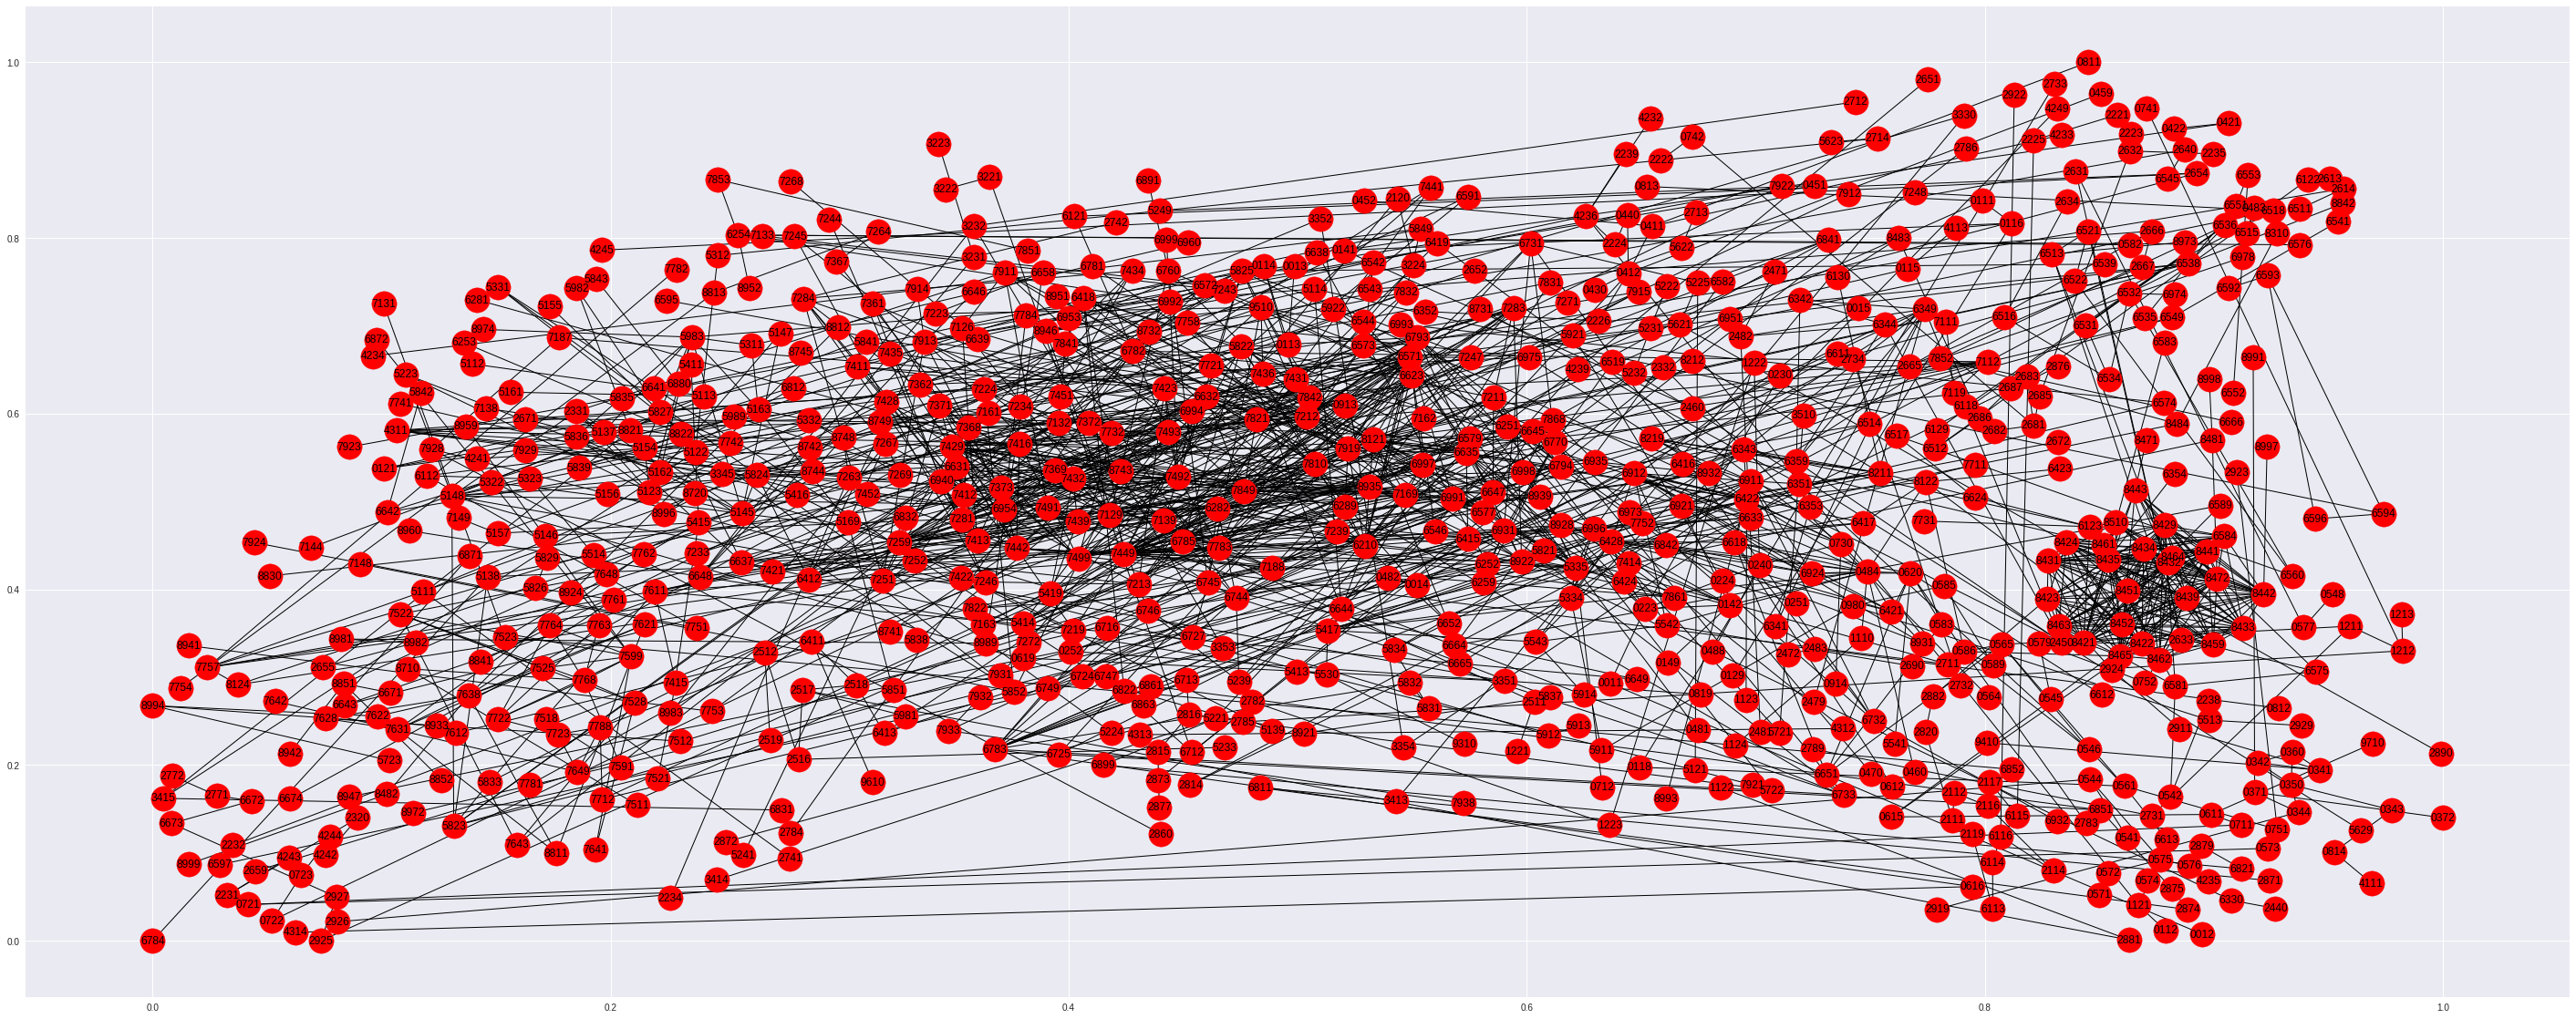

In [87]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(50,20))
ax = fig.gca()
nx.draw_networkx(ps, ax=ax, pos=coord, node_size=750, width=1)
plt.savefig("productspace1.png")

**Note:** File is saved Locally to view the network in greater detail

In [88]:
#-Let's See where Apparel Chapter 84 Nodes are Located-#
def choose_color(x):
    if x[:2] == "84":
        return "b"
    else:
        return "r"
    
nodes = pd.DataFrame(sorted(list(coord.keys())), columns=["nodeid"])
nodes["color"] = nodes["nodeid"].apply(lambda x: choose_color(x))

In [89]:
nodes[nodes.color == 'b'].head()

nodeid color
689   8421     b
690   8422     b
691   8423     b
692   8424     b
693   8429     b

In [90]:
#-Get the Order of Nodes the Same as Network Node List
order = pd.DataFrame(list(ps.nodes())).reset_index()
order.columns = ["order", "nodeid"]
nodes = nodes.merge(order, how="inner", on="nodeid")
nodes = nodes.sort_values(by="order")

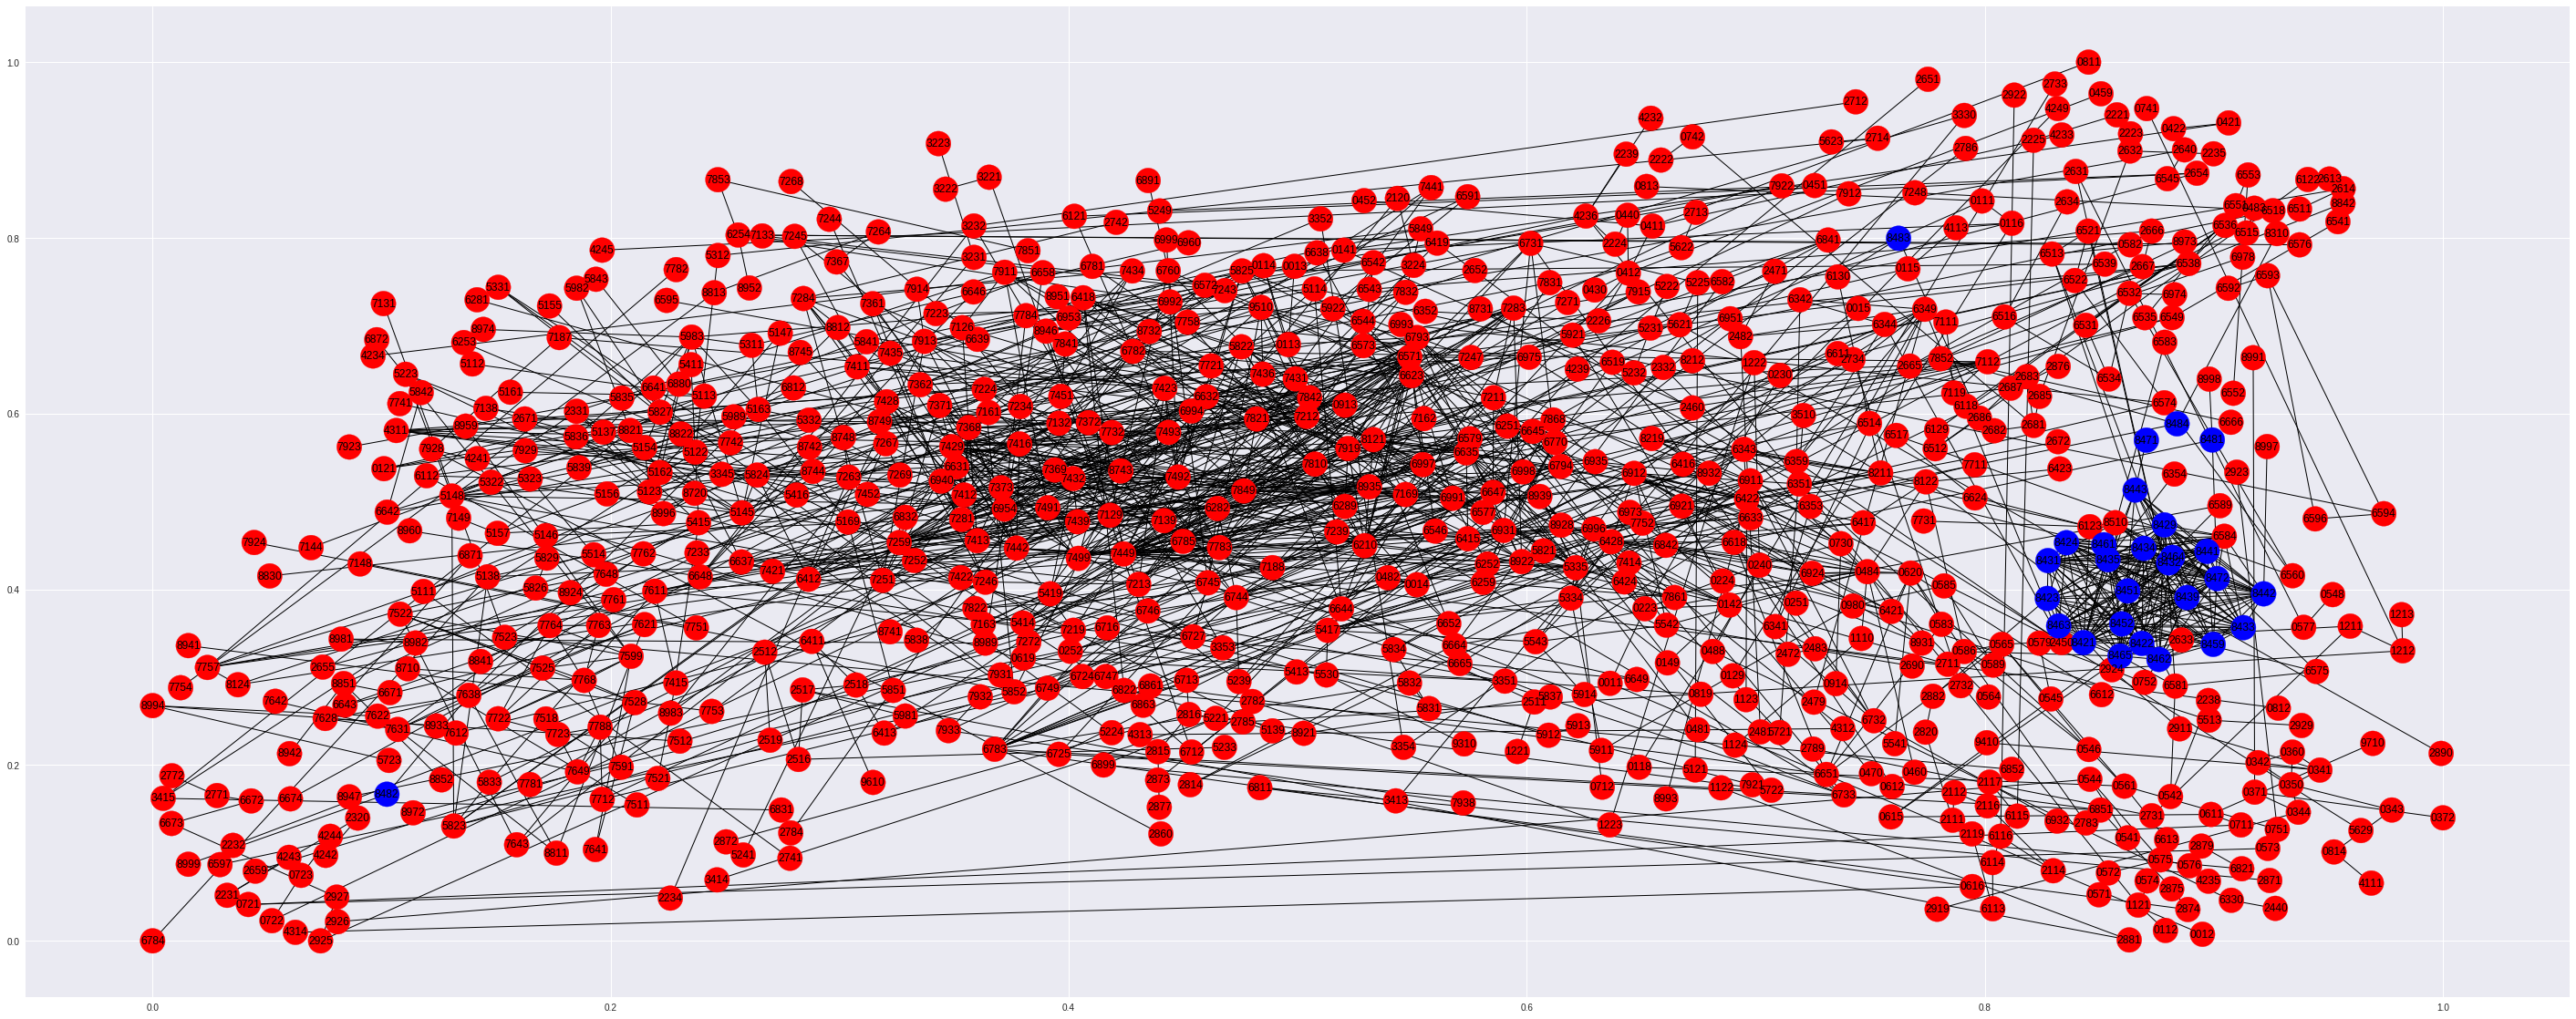

In [91]:
fig = plt.figure(figsize=(50,20))
ax = fig.gca()
nx.draw_networkx(ps, ax=ax, pos=coord, node_size=750, width=1, node_color = nodes.color.values, )
plt.savefig("productspace2.png")

# References

[1] Zachary, W. (1977), "An Information Flow Model for Conflict and Fission in Small Groups", Journal of Anthropological Research, Vol. 33, No. 4 (Winter, 1977), pp. 452-473

[2] Cao, X., Wang X., Jin D., Cao Y. & He, D. (2013), "Identifying overlapping communities as well as hubs and outliers via nonnegative matrix factorization", Scientific Reports, Vol 3, Issue 2993

[3] Hidalgo, C.A., Klinger, B., Barabasi, A.-L., Hausmann, R. (2007), "The Product Space Conditions the Development of Nations", Science, Vol 317, pp 482-487

[4] Atlas of Complexity (http://atlas.cid.harvard.edu/)

[5] The Observatory of Economic Complexity (http://atlas.media.mit.edu/en/)

[6] Atlas of Complexity Gride Points for Nodes sourced from http://www.michelecoscia.com/?page_id=223

[7] Balassa, B. (1965), "Trade Liberalisation and Revealed Comparative Advantage", The Manchester School, 33, 99-123.